In [ ]:
#This hybrid model for cnn and vit

In [ ]:
!pip uninstall -y typeguard inflect tensorflow-addons
!pip install tensorflow-addons inflect --no-deps


Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
  Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (611 kB)


In [2]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
import kagglehub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# ✅ Enable Mixed Precision for Faster Training and Lower Memory Usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable GPU Usage & Optimize Memory Growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

# ✅ Download Dataset via kagglehub
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")
print("✅ Dataset downloaded to:", dataset_path)

# ✅ Dynamically Detect Actual Data Path
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

# ✅ Verify Dataset Path
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path dynamically detected: {DATASET_PATH}")

# ✅ Load Classes
classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Define Image Sizes
IMG_SIZE_CNN = (128, 128)
IMG_SIZE_VIT = (224, 224)

# ✅ Image Generator Function
def image_generator(image_paths, labels):
    def gen():
        for img_path, label in zip(image_paths, labels):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_cnn = cv2.resize(img, IMG_SIZE_CNN) / 255.0
            img_vit = cv2.resize(img, IMG_SIZE_VIT) / 255.0

            yield (img_cnn, img_vit), label

    output_signature = (
        (tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

# ✅ Load Image Paths & Labels
image_paths = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG") + glob.glob(class_path + "/*.jpg")

    if not imgs:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue

    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Train-Validation-Test Split
img_train, img_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(
    img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"✅ Split sizes — Train: {len(img_train)}, Val: {len(img_val)}, Test: {len(img_test)}")

# ✅ Create Data Pipelines
train_dataset = image_generator(img_train, y_train).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_dataset = image_generator(img_val, y_val).batch(16).prefetch(tf.data.AUTOTUNE)
test_dataset = image_generator(img_test, y_test).batch(16).prefetch(tf.data.AUTOTUNE)

print("✅ Data Generators Ready!")


✅ GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


100%|██████████| 444M/444M [00:03<00:00, 118MB/s]

Extracting files...


✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1
✅ Dataset path dynamically detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']
✅ Split sizes — Train: 7572, Val: 947, Test: 947
✅ Data Generators Ready!


✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
    474/Unknown 135s 216ms/step - accuracy: 0.8142 - loss: 0.5703

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


474/474 ━━━━━━━━━━━━━━━━━━━━ 162s 273ms/step - accuracy: 0.8143 - loss: 0.5697 - val_accuracy: 0.9630 - val_loss: 0.1059
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.9604 - loss: 0.1208 - val_accuracy: 0.9810 - val_loss: 0.0509
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 105s 222ms/step - accuracy: 0.9765 - loss: 0.0835 - val_accuracy: 0.9820 - val_loss: 0.0620
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 105s 222ms/step - accuracy: 0.9748 - loss: 0.0769 - val_accuracy: 0.9937 - val_loss: 0.0287
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 142s 223ms/step - accuracy: 0.9785 - loss: 0.0611 - val_accuracy: 0.9884 - val_loss: 0.0284
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 105s 222ms/step - accuracy: 0.9832 - loss: 0.0513 - val_accuracy: 0.9863 - val_loss: 0.0311
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 105s 222ms/step - accuracy: 0.9866 - loss: 0.0428 - val_accuracy: 0.9789 - val_loss: 0.0586
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.9823 - loss: 0.04

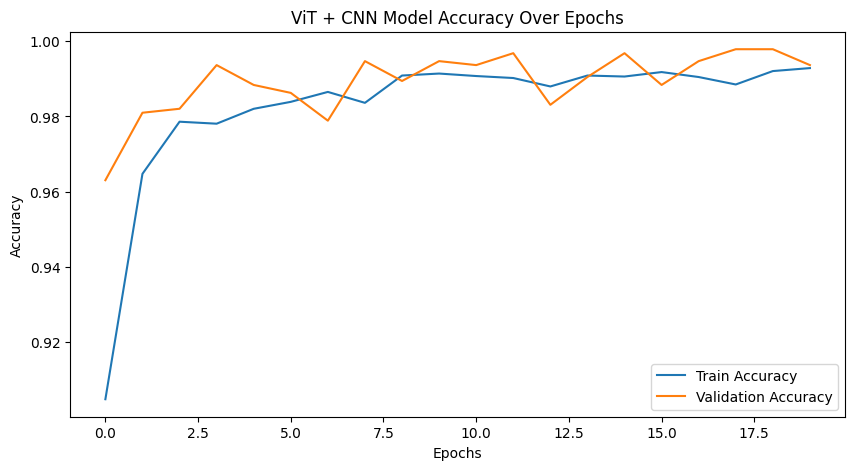

In [ ]:
# ✅ Import Required Libraries
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization, Layer, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from transformers import TFViTModel

# ✅ Enable Mixed Precision for Faster Training and Lower Memory Usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Define CNN Backbone (Feature Extractor)
def cnn_backbone(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers
    x = GlobalAveragePooling2D()(base_model.output)  # Reduce spatial dimensions
    return Model(inputs=base_model.input, outputs=x, name="CNN_Backbone")

# ✅ Define ViT Feature Extractor with Correct Input Shape
class ViTFeatureExtractor(Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        self.vit.trainable = False  # Freeze ViT weights

    def call(self, inputs, training=False):
        # ✅ Convert NHWC (TensorFlow format) → NCHW (ViT expected format)
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])  # Change shape (B, 224, 224, 3) → (B, 3, 224, 224)

        # ✅ Pass transposed images to ViT
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state

        # ✅ Apply Global Pooling to Extract Features
        return GlobalAveragePooling1D()(vit_outputs)

def vit_model(input_shape):
    vit_input = Input(shape=input_shape)
    vit_features = ViTFeatureExtractor()(vit_input)  # Wrap ViT inside a Keras Layer
    return tf.keras.Model(inputs=vit_input, outputs=vit_features, name="ViT_FeatureExtractor")

# ✅ Load Dataset Paths
DATASET_PATH = "/content/mstar-dataset/Padded_imgs"
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")

classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG")

    if not imgs:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue

    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Train-Validation-Test Split
from sklearn.model_selection import train_test_split

img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Define Image Generator (Returns One-Hot Encoded Labels)
def image_generator(image_paths, labels, num_classes):
    def gen():
        for img_path, label in zip(image_paths, labels):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img_cnn = cv2.resize(img, (128, 128)) / 255.0  # Normalize
            img_vit = cv2.resize(img, (224, 224)) / 255.0  # Normalize

            yield (img_cnn, img_vit), to_categorical(label, num_classes=num_classes)  # ✅ One-hot encode label

    output_signature = (
        (tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),  # CNN Input
         tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)),  # ViT Input
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)  # ✅ Fix: One-hot encoded labels
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

# ✅ Create Dataset Generators
batch_size = 16

train_dataset = image_generator(img_train, y_train, num_classes).batch(batch_size)
val_dataset = image_generator(img_val, y_val, num_classes).batch(batch_size)
test_dataset = image_generator(img_test, y_test, num_classes).batch(batch_size)

# ✅ Create Hybrid Model
input_layer_cnn = Input(shape=(128, 128, 3))
input_layer_vit = Input(shape=(224, 224, 3))

cnn_features = cnn_backbone(input_shape=(128, 128, 3))(input_layer_cnn)
vit_features = vit_model(input_shape=(224, 224, 3))(input_layer_vit)

merged = Concatenate()([cnn_features, vit_features])

x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

hybrid_model = Model(inputs=[input_layer_cnn, input_layer_vit], outputs=output_layer, name="ViT_CNN_Hybrid")

# ✅ Define Adaptive Learning Rate Scheduler
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

# ✅ Compile Model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train Model with GPU
with tf.device('/GPU:0'):
    history_hybrid = hybrid_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20
    )

# ✅ Evaluate Model
loss, accuracy = hybrid_model.evaluate(test_dataset)
print(f"✅ Hybrid ViT + CNN Model Accuracy: {accuracy:.4f}")

# ✅ Save Model
hybrid_model.save("/content/mstar_vit_cnn.keras")
print("🎯 Model training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10,5))
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ViT + CNN Model Accuracy Over Epochs')
plt.show()


In [ ]:
#Finetune,unfreez more layers

✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
    474/Unknown 252s 305ms/step - accuracy: 0.7925 - loss: 0.6725

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


474/474 ━━━━━━━━━━━━━━━━━━━━ 281s 365ms/step - accuracy: 0.7927 - loss: 0.6717 - val_accuracy: 0.6758 - val_loss: 0.9064
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 114s 239ms/step - accuracy: 0.9846 - loss: 0.0605 - val_accuracy: 0.5333 - val_loss: 2.1636
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 115s 242ms/step - accuracy: 0.9801 - loss: 0.0582 - val_accuracy: 0.9989 - val_loss: 0.0059
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 244ms/step - accuracy: 0.9926 - loss: 0.0279 - val_accuracy: 1.0000 - val_loss: 6.4483e-04
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 244ms/step - accuracy: 0.9989 - loss: 0.0054 - val_accuracy: 0.9461 - val_loss: 0.1637
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 244ms/step - accuracy: 0.9915 - loss: 0.0320 - val_accuracy: 0.9968 - val_loss: 0.0081
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 244ms/step - accuracy: 0.9987 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 116s 244ms/step - accuracy: 0.9974 - loss: 

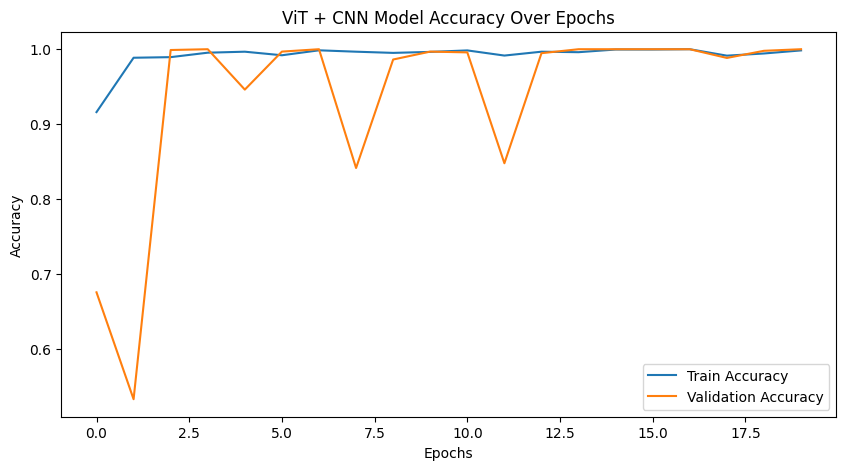

In [6]:
# ✅ Import Required Libraries
import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate,
    BatchNormalization, Layer, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from transformers import TFViTModel
from sklearn.model_selection import train_test_split
from transformers import TFViTModel


# ✅ Enable Mixed Precision for Faster Training and Lower Memory Usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# ✅ Define CNN Backbone (Feature Extractor) with partial unfreezing
def cnn_backbone(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[-20:]:  # ✅ Unfreeze last 20 layers of ResNet
        layer.trainable = True
    x = GlobalAveragePooling2D()(base_model.output)
    return Model(inputs=base_model.input, outputs=x, name="CNN_Backbone")

# ✅ Define ViT Feature Extractor with partial unfreezing
class ViTFeatureExtractor(Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        self.vit.trainable = True  # Allow fine-tuning

        # ✅ Safely unfreeze last 5 transformer blocks
        try:
            # Check if model has 'encoder' (not all do)
            for layer in self.vit.vit.encoder.layer[-5:]:
                layer.trainable = True
        except AttributeError:
            print("⚠️ Could not access 'encoder.layer'. Skipping selective unfreezing. All layers trainable.")

    def call(self, inputs, training=False):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])  # (B, 224, 224, 3) -> (B, 3, 224, 224)
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state
        return GlobalAveragePooling1D()(vit_outputs)

# ✅ Create ViT Feature Extractor Wrapper
def vit_model(input_shape):
    vit_input = Input(shape=input_shape)
    vit_features = ViTFeatureExtractor()(vit_input)
    return tf.keras.Model(inputs=vit_input, outputs=vit_features, name="ViT_FeatureExtractor")

import kagglehub
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG")
    if not imgs:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue
    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Split Dataset
img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Image Generator
def image_generator(image_paths, labels, num_classes):
    def gen():
        for img_path, label in zip(image_paths, labels):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_cnn = cv2.resize(img, (128, 128)) / 255.0
            img_vit = cv2.resize(img, (224, 224)) / 255.0
            yield (img_cnn, img_vit), to_categorical(label, num_classes=num_classes)

    output_signature = (
        (tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
         tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32)),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)

# ✅ Create Datasets
batch_size = 16
train_dataset = image_generator(img_train, y_train, num_classes).batch(batch_size)
val_dataset = image_generator(img_val, y_val, num_classes).batch(batch_size)
test_dataset = image_generator(img_test, y_test, num_classes).batch(batch_size)

# ✅ Build Hybrid Model
input_layer_cnn = Input(shape=(128, 128, 3))
input_layer_vit = Input(shape=(224, 224, 3))
cnn_features = cnn_backbone(input_shape=(128, 128, 3))(input_layer_cnn)
vit_features = vit_model(input_shape=(224, 224, 3))(input_layer_vit)
merged = Concatenate()([cnn_features, vit_features])
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

hybrid_model = Model(inputs=[input_layer_cnn, input_layer_vit], outputs=output_layer, name="ViT_CNN_Hybrid")

# ✅ Learning Rate Schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# ✅ Compile Model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train Model
with tf.device('/GPU:0'):
    history_hybrid = hybrid_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20
    )

# ✅ Evaluate Model
loss, accuracy = hybrid_model.evaluate(test_dataset)
print(f"✅ Hybrid ViT + CNN Model Accuracy: {accuracy:.4f}")

# ✅ Save Model
hybrid_model.save("/content/mstar_vit_cnn.keras")
print("🎯 Model training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10,5))
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('ViT + CNN Model Accuracy Over Epochs')
plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 342ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


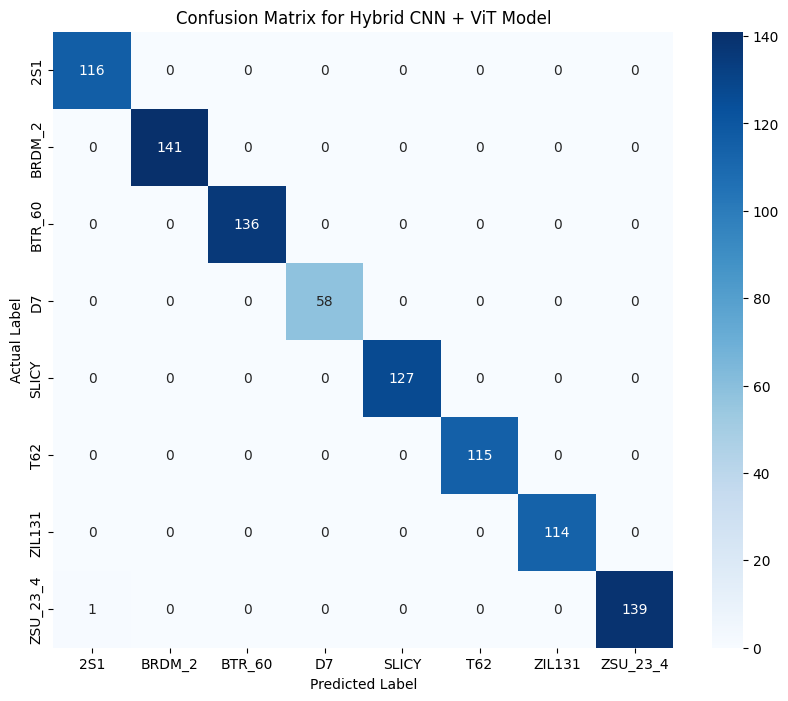


Classification Report:

              precision    recall  f1-score   support

         2S1       0.99      1.00      1.00       116
      BRDM_2       1.00      1.00      1.00       141
      BTR_60       1.00      1.00      1.00       136
          D7       1.00      1.00      1.00        58
       SLICY       1.00      1.00      1.00       127
         T62       1.00      1.00      1.00       115
      ZIL131       1.00      1.00      1.00       114
    ZSU_23_4       1.00      0.99      1.00       140

    accuracy                           1.00       947
   macro avg       1.00      1.00      1.00       947
weighted avg       1.00      1.00      1.00       947



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate predictions
y_pred = hybrid_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from test_dataset
y_true_classes = np.concatenate([np.argmax(labels.numpy(), axis=1) for _, labels in test_dataset])

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Hybrid CNN + ViT Model")
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


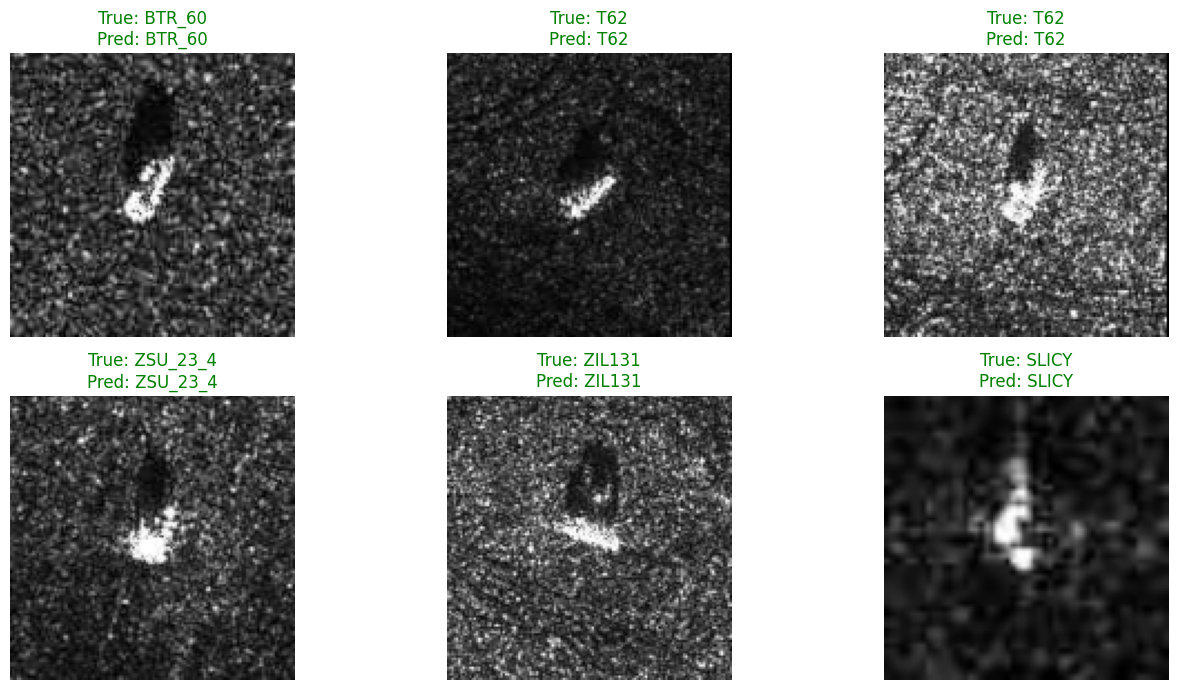

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of test samples
(test_images_cnn, test_images_vit), test_labels = next(iter(test_dataset))
predictions = hybrid_model.predict([test_images_cnn, test_images_vit])

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels.numpy(), axis=1)

# Function to visualize predictions
def plot_predictions(images, true_labels, predicted_labels, class_names, num_samples=6):
    plt.figure(figsize=(14, 7))
    for i in range(num_samples):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        pred_label = class_names[predicted_labels[i]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Visualize the CNN-sized images (128x128)
plot_predictions(test_images_cnn.numpy(), true_classes, predicted_classes, classes)


In [10]:
# ✅ Import Necessary Libraries
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, BatchNormalization, Lambda, GlobalAveragePooling1D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from transformers import TFViTModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ✅ Enable Mixed Precision for Faster Training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# ✅ Enable GPU & Optimize Memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

import kagglehub

# ✅ Download dataset
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")
print("✅ Dataset downloaded to:", dataset_path)

# ✅ Handle kagglehub versioning
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path dynamically detected: {DATASET_PATH}")

# ✅ Load Class Names
classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths, labels = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG")

    if not imgs:
        print(f"⚠️ Warning: No images found in {class_path}")
        continue

    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Train-Validation-Test Split
img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Define Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# ✅ Fix Dataset Loading to Ensure Two Inputs
def dual_input_generator(image_paths, labels, batch_size, num_classes):
    def load_and_preprocess(image_path, label):
        image_path = image_path.numpy().decode("utf-8")
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ✅ Resize images for CNN (128x128) and ViT (224x224)
        img_cnn = cv2.resize(img, (128, 128)) / 255.0
        img_vit = cv2.resize(img, (224, 224)) / 255.0

        # ✅ Convert Label to One-Hot
        label_one_hot = tf.one_hot(label, num_classes)

        return img_cnn.astype(np.float32), img_vit.astype(np.float32), label_one_hot

    def tf_preprocess(image_path, label):
        cnn_input, vit_input, one_hot_label = tf.py_function(load_and_preprocess, [image_path, label],
                                                              [tf.float32, tf.float32, tf.float32])
        cnn_input.set_shape([128, 128, 3])
        vit_input.set_shape([224, 224, 3])
        one_hot_label.set_shape([num_classes])

        return (cnn_input, vit_input), one_hot_label

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.shuffle(len(image_paths)).map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

# ✅ Define batch size
batch_size = 16

# ✅ Apply Fix to Train, Validation, and Test Datasets
train_dataset = dual_input_generator(img_train, y_train, batch_size, num_classes)
val_dataset = dual_input_generator(img_val, y_val, batch_size, num_classes)
test_dataset = dual_input_generator(img_test, y_test, batch_size, num_classes)


# ✅ Define CNN Backbone (Feature Extractor)
def cnn_backbone(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze pretrained layers
    x = GlobalAveragePooling2D()(base_model.output)  # Reduce spatial dimensions
    return Model(inputs=base_model.input, outputs=x, name="CNN_Backbone")

# ✅ Define ViT Feature Extractor
class ViTFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        for layer in self.vit.layers[-5:]:  # ✅ Unfreeze last 5 ViT layers for fine-tuning
            layer.trainable = True

    def call(self, inputs, training=False):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state
        return GlobalAveragePooling1D()(vit_outputs)

# ✅ Create Hybrid Model
input_layer_cnn = Input(shape=(128, 128, 3))
input_layer_vit = Input(shape=(224, 224, 3))

cnn_features = cnn_backbone(input_shape=(128, 128, 3))(input_layer_cnn)
vit_features = ViTFeatureExtractor()(input_layer_vit)

merged = Concatenate()([cnn_features, vit_features])

x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

hybrid_model = Model(inputs=[input_layer_cnn, input_layer_vit], outputs=output_layer, name="ViT_CNN_Hybrid")

# ✅ Compile Model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train Hybrid Model
with tf.device('/GPU:0'):
    history_hybrid = hybrid_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20
    )

# ✅ Evaluate Model
loss, accuracy = hybrid_model.evaluate(test_dataset)
print(f"✅ Hybrid CNN-ViT Model Accuracy: {accuracy:.4f}")

hybrid_model.save("/content/mstar_hybrid_vit_cnn.keras")
print("🎯 Hybrid CNN-ViT training completed and saved successfully!")

✅ GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}
✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1
✅ Dataset path dynamically detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 174s 307ms/step - accuracy: 0.8133 - loss: 0.5709 - val_accuracy: 0.9725 - val_loss: 0.0868
Epoch 2/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 175s 269ms/step - accuracy: 0.9644 - loss: 0.1122 - val_accuracy: 0.9820 - val_loss: 0.0600
Epoch 3/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.9769 - loss: 0.0815 - val_accuracy: 0.9842 - val_loss: 0.0472
Epoch 4/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 128s 269ms/step - accuracy: 0.9750 - loss: 0.0735 - val_accuracy: 0.9884 - val_loss: 0.0322
Epoch 5/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.9766 - loss: 0.0692 - val_accuracy: 0.9778 - val_loss: 0.0631
Epoch 6/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 120s 254ms/step - accuracy: 0.9836 - loss: 0.0531 - val_accuracy: 0.9842 - val_loss: 0.0388
Epoch 7/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 149s 269ms/step - accuracy: 0.9844 - loss: 0.0489 - val_accuracy: 0.9905 - val_loss: 0.0384
Epoch 8/20
474/474 ━━━━━━━━━━━━━━━━━━━━ 135s 254ms/step - accuracy: 0.9888 -

✅ GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. 

✅ Pretrained Hybrid CNN-ViT Model Loaded!
✅ Dataset path dynamically detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']
✅ Siamese Network with Hybrid CNN-ViT initialized successfully!
Epoch 1/10
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 515s 242ms/step - accuracy: 0.7929 - loss: 0.5643 - val_accuracy: 0.9483 - val_loss: 0.3187
Epoch 2/10
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 481s 241ms/step - accuracy: 0.9056 - loss: 0.3402 - val_accuracy: 0.9604 - val_loss: 0.2203
Epoch 3/10
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 501s 241ms/step - accuracy: 0.9083 - loss: 0.2823 - val_accuracy: 0.9588 - val_loss: 0.1951
Epoch 4/10
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 502s 241ms/step - accuracy: 0.9124 - loss: 0.2619 - val_accuracy: 0.9583 - val_loss: 0.1830
Epoch 5/10
1893/1893 ━━━━━━━━━━━━━━━━━━━━ 502s 241ms/step - accuracy: 0.9186 - loss: 0.2441 - val_accuracy: 0.9525 - val_loss: 0.1775
Ep

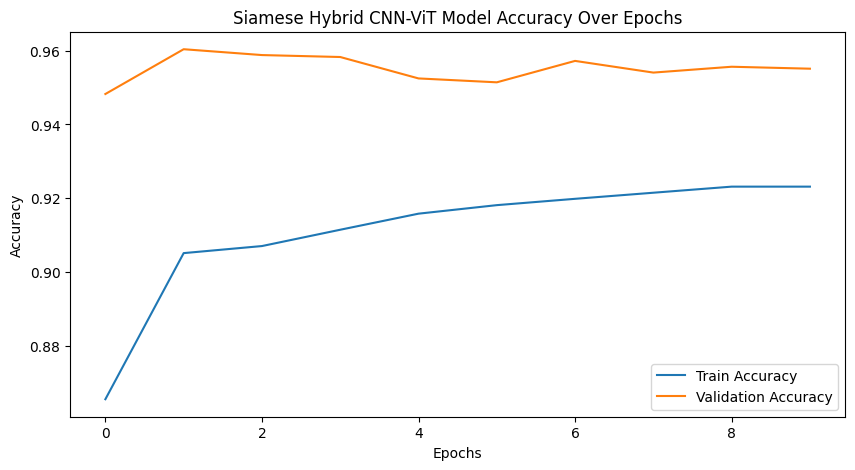

In [1]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense
import random

# ✅ Enable GPU & Optimize Memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

from transformers import TFViTModel
from tensorflow.keras.layers import GlobalAveragePooling1D

# ✅ Define the same ViTFeatureExtractor class used during model training
class ViTFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        for layer in self.vit.layers[-5:]:  # Unfreeze last 5 layers for fine-tuning
            layer.trainable = True

    def call(self, inputs, training=False):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])  # Convert to channels-first
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state
        return GlobalAveragePooling1D()(vit_outputs)

# ✅ Check model path exists
hybrid_model_path = "/content/mstar_hybrid_vit_cnn.keras"
if not os.path.exists(hybrid_model_path):
    raise FileNotFoundError(f"❌ Hybrid model not found at {hybrid_model_path}")

# ✅ Load the Pretrained Hybrid CNN-ViT Model using the correct custom layer
hybrid_model = load_model(hybrid_model_path, custom_objects={"ViTFeatureExtractor": ViTFeatureExtractor})
print("✅ Pretrained Hybrid CNN-ViT Model Loaded!")

import kagglehub

# ✅ Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

# ✅ Dynamically resolve the actual dataset folder
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path dynamically detected: {DATASET_PATH}")

classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths, labels = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG")
    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Train-Validation-Test Split
from sklearn.model_selection import train_test_split
img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Generate Image Pairs for Siamese Network
def generate_siamese_pairs(image_paths, labels, num_classes):
    pairs, pair_labels = [], []
    class_indices = {i: np.where(np.array(labels) == i)[0].tolist() for i in range(num_classes)}

    for i, img_path in enumerate(image_paths):
        if len(class_indices[labels[i]]) < 2:
            continue

        # ✅ Positive Pair
        positive_index = random.choice(class_indices[labels[i]])
        pairs.append((img_path, image_paths[positive_index]))
        pair_labels.append(1)

        # ✅ Negative Pair
        negative_class = random.choice(list(set(range(num_classes)) - {labels[i]}))
        negative_index = random.choice(class_indices[negative_class])
        pairs.append((img_path, image_paths[negative_index]))
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

# ✅ Generate Training and Validation Pairs
siamese_train_pairs, siamese_train_labels = generate_siamese_pairs(img_train, y_train, num_classes)
siamese_val_pairs, siamese_val_labels = generate_siamese_pairs(img_val, y_val, num_classes)

# ✅ Streaming tf.data pipeline for memory-safe loading
def siamese_pair_dataset(pairs, labels, batch_size):
    def preprocess(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return tf.image.convert_image_dtype(img, tf.float32)

    def preprocess_pair(img_a_path, img_b_path, label):
        img_a = preprocess(img_a_path)
        img_b = preprocess(img_b_path)

        img_a_cnn = tf.image.resize(img_a, [128, 128])
        img_b_cnn = tf.image.resize(img_b, [128, 128])
        img_a_vit = tf.image.resize(img_a, [224, 224])
        img_b_vit = tf.image.resize(img_b, [224, 224])

        return (img_a_cnn, img_a_vit, img_b_cnn, img_b_vit), label

    img_a_paths = [pair[0] for pair in pairs]
    img_b_paths = [pair[1] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img_a_paths, img_b_paths, labels))
    dataset = dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ✅ Prepare streamed training/validation datasets
batch_size = 8
train_dataset = siamese_pair_dataset(siamese_train_pairs, siamese_train_labels, batch_size)
val_dataset = siamese_pair_dataset(siamese_val_pairs, siamese_val_labels, batch_size)

# ✅ Define Siamese Network Using Hybrid CNN-ViT
def siamese_network(base_model):
    input_a_cnn = Input(shape=(128, 128, 3))
    input_a_vit = Input(shape=(224, 224, 3))
    input_b_cnn = Input(shape=(128, 128, 3))
    input_b_vit = Input(shape=(224, 224, 3))

    feat_a = base_model([input_a_cnn, input_a_vit])
    feat_b = base_model([input_b_cnn, input_b_vit])

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat_a, feat_b])
    output = Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[input_a_cnn, input_a_vit, input_b_cnn, input_b_vit], outputs=output, name="Siamese_Hybrid_Network")

# ✅ Initialize Siamese Network
siamese = siamese_network(hybrid_model)
siamese.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("✅ Siamese Network with Hybrid CNN-ViT initialized successfully!")

# ✅ Train the Siamese Model
history_siamese = siamese.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# ✅ Evaluate Siamese Model
loss, accuracy = siamese.evaluate(val_dataset)
print(f"✅ Siamese-Hybrid CNN-ViT Model Accuracy: {accuracy:.4f}")

# ✅ Save the Siamese Model
siamese.save("/content/mstar_siamese_hybrid.keras")
print("🎯 Siamese-Hybrid CNN-ViT training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(history_siamese.history['accuracy'], label='Train Accuracy')
plt.plot(history_siamese.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Siamese Hybrid CNN-ViT Model Accuracy Over Epochs')
plt.show()


In [ ]:
import os
import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Lambda, Dense
import random

# ✅ Enable GPU & Optimize Memory
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"✅ GPU Detected: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("❌ No GPU detected, running on CPU.")

from transformers import TFViTModel
from tensorflow.keras.layers import GlobalAveragePooling1D

# ✅ Define the same ViTFeatureExtractor class used during model training
class ViTFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, model_name="google/vit-base-patch16-224", **kwargs):
        super(ViTFeatureExtractor, self).__init__(**kwargs)
        self.vit = TFViTModel.from_pretrained(model_name)
        for layer in self.vit.layers[-5:]:  # Unfreeze last 5 layers for fine-tuning
            layer.trainable = True

    def call(self, inputs, training=False):
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])  # Convert to channels-first
        vit_outputs = self.vit(pixel_values=inputs, training=training).last_hidden_state
        return GlobalAveragePooling1D()(vit_outputs)

# ✅ Check model path exists
hybrid_model_path = "/content/mstar_hybrid_vit_cnn.keras"
if not os.path.exists(hybrid_model_path):
    raise FileNotFoundError(f"❌ Hybrid model not found at {hybrid_model_path}")

# ✅ Load the Pretrained Hybrid CNN-ViT Model using the correct custom layer
hybrid_model = load_model(hybrid_model_path, custom_objects={"ViTFeatureExtractor": ViTFeatureExtractor})
print("✅ Pretrained Hybrid CNN-ViT Model Loaded!")

import kagglehub

# ✅ Download dataset using kagglehub
dataset_path = kagglehub.dataset_download("atreyamajumdar/mstar-dataset-8-classes")

# ✅ Dynamically resolve the actual dataset folder
if "versions" in dataset_path:
    DATASET_PATH = os.path.join(dataset_path, "Padded_imgs")
else:
    DATASET_PATH = os.path.join(dataset_path, "versions", "1", "Padded_imgs")

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"❌ Dataset path does not exist: {DATASET_PATH}")
print(f"✅ Dataset path dynamically detected: {DATASET_PATH}")

classes = sorted(os.listdir(DATASET_PATH))
num_classes = len(classes)
print(f"✅ Found {num_classes} classes: {classes}")

# ✅ Load Image Paths & Labels
image_paths, labels = [], []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(DATASET_PATH, class_name)
    imgs = glob.glob(class_path + "/*.JPG")
    image_paths.extend(imgs)
    labels.extend([class_idx] * len(imgs))

# ✅ Train-Validation-Test Split
from sklearn.model_selection import train_test_split
img_train, img_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.2, stratify=labels, random_state=42)
img_val, img_test, y_val, y_test = train_test_split(img_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Generate Image Pairs for Siamese Network
def generate_siamese_pairs(image_paths, labels, num_classes):
    pairs, pair_labels = [], []
    class_indices = {i: np.where(np.array(labels) == i)[0].tolist() for i in range(num_classes)}

    for i, img_path in enumerate(image_paths):
        if len(class_indices[labels[i]]) < 2:
            continue

        # ✅ Positive Pair
        positive_index = random.choice(class_indices[labels[i]])
        pairs.append((img_path, image_paths[positive_index]))
        pair_labels.append(1)

        # ✅ Negative Pair
        negative_class = random.choice(list(set(range(num_classes)) - {labels[i]}))
        negative_index = random.choice(class_indices[negative_class])
        pairs.append((img_path, image_paths[negative_index]))
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

# ✅ Generate Training and Validation Pairs
siamese_train_pairs, siamese_train_labels = generate_siamese_pairs(img_train, y_train, num_classes)
siamese_val_pairs, siamese_val_labels = generate_siamese_pairs(img_val, y_val, num_classes)

# ✅ Streaming tf.data pipeline for memory-safe loading
def siamese_pair_dataset(pairs, labels, batch_size):
    def preprocess(img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        return tf.image.convert_image_dtype(img, tf.float32)

    def preprocess_pair(img_a_path, img_b_path, label):
        img_a = preprocess(img_a_path)
        img_b = preprocess(img_b_path)

        img_a_cnn = tf.image.resize(img_a, [128, 128])
        img_b_cnn = tf.image.resize(img_b, [128, 128])
        img_a_vit = tf.image.resize(img_a, [224, 224])
        img_b_vit = tf.image.resize(img_b, [224, 224])

        return (img_a_cnn, img_a_vit, img_b_cnn, img_b_vit), label

    img_a_paths = [pair[0] for pair in pairs]
    img_b_paths = [pair[1] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((img_a_paths, img_b_paths, labels))
    dataset = dataset.map(preprocess_pair, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# ✅ Prepare streamed training/validation datasets
batch_size = 16
train_dataset = siamese_pair_dataset(siamese_train_pairs, siamese_train_labels, batch_size)
val_dataset = siamese_pair_dataset(siamese_val_pairs, siamese_val_labels, batch_size)

# ✅ Define Siamese Network Using Hybrid CNN-ViT
def siamese_network(base_model):
    input_a_cnn = Input(shape=(128, 128, 3))
    input_a_vit = Input(shape=(224, 224, 3))
    input_b_cnn = Input(shape=(128, 128, 3))
    input_b_vit = Input(shape=(224, 224, 3))

    feat_a = base_model([input_a_cnn, input_a_vit])
    feat_b = base_model([input_b_cnn, input_b_vit])

    distance = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))([feat_a, feat_b])
    output = Dense(1, activation='sigmoid')(distance)

    return Model(inputs=[input_a_cnn, input_a_vit, input_b_cnn, input_b_vit], outputs=output, name="Siamese_Hybrid_Network")

# ✅ Initialize Siamese Network
siamese = siamese_network(hybrid_model)
siamese.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print("✅ Siamese Network with Hybrid CNN-ViT initialized successfully!")

# ✅ Train the Siamese Model
history_siamese = siamese.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# ✅ Evaluate Siamese Model
loss, accuracy = siamese.evaluate(val_dataset)
print(f"✅ Siamese-Hybrid CNN-ViT Model Accuracy: {accuracy:.4f}")

# ✅ Save the Siamese Model
siamese.save("/content/mstar_siamese_hybrid.keras")
print("🎯 Siamese-Hybrid CNN-ViT training completed and saved successfully!")

# ✅ Plot Training Curves
plt.figure(figsize=(10, 5))
plt.plot(history_siamese.history['accuracy'], label='Train Accuracy')
plt.plot(history_siamese.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Siamese Hybrid CNN-ViT Model Accuracy Over Epochs')
plt.show()


✅ GPU Detected: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFViTModel were not initialized from the PyTorch model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer '

✅ Pretrained Hybrid CNN-ViT Model Loaded!
✅ Dataset path dynamically detected: /root/.cache/kagglehub/datasets/atreyamajumdar/mstar-dataset-8-classes/versions/1/Padded_imgs
✅ Found 8 classes: ['2S1', 'BRDM_2', 'BTR_60', 'D7', 'SLICY', 'T62', 'ZIL131', 'ZSU_23_4']
✅ Siamese Network with Hybrid CNN-ViT initialized successfully!
Epoch 1/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 508s 479ms/step - accuracy: 0.6948 - loss: 0.5816 - val_accuracy: 0.8870 - val_loss: 0.4026
Epoch 2/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 461s 454ms/step - accuracy: 0.8845 - loss: 0.3876 - val_accuracy: 0.8907 - val_loss: 0.3381
Epoch 3/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 442s 455ms/step - accuracy: 0.8850 - loss: 0.3379 - val_accuracy: 0.8886 - val_loss: 0.3153
Epoch 4/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 442s 455ms/step - accuracy: 0.8880 - loss: 0.3166 - val_accuracy: 0.8833 - val_loss: 0.3175
Epoch 5/20
947/947 ━━━━━━━━━━━━━━━━━━━━ 442s 454ms/step - accuracy: 0.8895 - loss: 0.3083 - val_accuracy: 0.8875 - val_loss: 0.3047
Epoch 6/20
9